# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is for model training and testing

#### Import python library

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#Import models from scikit learn module:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

import h5py
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger

import pickle
import joblib
import os

from ModelDefinitions import createModel

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
    #***********************************
    # Index 00-10 is for LSTM Model
    # Index 11-20 is for Bi-LSTM Model
    # Index 21-30 is for CNN Model
    # Index 31-40 is for CNN-LSTM Model
    #***********************************

# choose a number of time steps
n_steps_in, predict_next_no_of_output = 3, 2

# ------ CHANGE THESE ------
index = 2
seed  = 7
np.random.seed(seed)
basemodelname = 'LSTM2-' + str(n_steps_in) + 'in' + str(predict_next_no_of_output) + 'out'
batch_size    = 8192
no_of_epoch   = 20
no_of_train   = 0.8
# --------------------------

modelname = 'model/' + basemodelname + "_" + str(index)
filepath  = modelname + ".hdf5"

## Define Functions

In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


## Read in Dataset

In [6]:
xls  = pd.ExcelFile('data/Dataset_feature.xlsx')
data = pd.read_excel(xls, 'TrafficMgmt')
data

,day,hour,min,dow,lat,long,demand
0,0.283333,0.869565,0.000000,0.285714,0.533333,0.171429,0.020072
1,0.150000,0.608696,0.666667,0.285714,0.288889,0.200000,0.024721
2,0.133333,0.260870,0.333333,0.142857,0.644444,0.828571,0.102821
3,0.516667,0.217391,0.000000,0.000000,0.533333,0.428571,0.088755
4,0.233333,0.173913,0.000000,1.000000,0.288889,0.342857,0.074468
...,...,...,...,...,...,...,...
1048570,0.083333,0.347826,0.666667,0.857143,0.911111,0.771429,0.024022
1048571,0.366667,0.652174,0.666667,1.000000,0.111111,0.400000,0.005703
1048572,0.683333,0.652174,1.000000,0.285714,0.533333,0.200000,0.067131
1048573,0.016667,0.260870,0.666667,0.285714,0.711111,0.600000,0.151323


In [7]:
predictor_var = ['day','hour','min','dow','lat','long']
outcome_var   = 'demand'
no_of_features = len(predictor_var)

#### Prepare training & test data

In [8]:
# convert into input/output
dataset = data.to_numpy()
X, y = split_sequences(dataset, n_steps_in, predict_next_no_of_output)
    
# Train-test-val dataset split
X_train1 = X[:int(no_of_train*len(X))]
y_train1 = y[:int(no_of_train*len(X))]
X_test  = X[int(no_of_train*len(X)):]
y_test  = y[int(no_of_train*len(X)):]

X_train = X_train1[:int(no_of_train*len(X_train1))]
y_train = y_train1[:int(no_of_train*len(X_train1))]
X_val   = X_train1[int(no_of_train*len(X_train1)):]
y_val   = y_train1[int(no_of_train*len(X_train1)):]


In [9]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(671085, 3, 6) (671085, 2) (209715, 3, 6) (209715, 2) (167772, 3, 6) (167772, 2)


### Main Program

In [10]:
def main():
    
    #***********************************
    # Index 00-10 is for LSTM Model
    # Index 11-20 is for Bi-LSTM Model
    # Index 21-30 is for CNN Model
    # Index 31-40 is for CNN-LSTM Model
    #***********************************

    # Create model and summary
    model = createModel(X_train, predict_next_no_of_output, index) #
    model.summary()
    
    # Create checkpoint for the training
    # This checkpoint performs model saving when
    # an epoch gives highest testing accuracy  
    checkpoint     = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min') 
    
    # Log the epoch detail into csv
    csv_logger     = CSVLogger(modelname + '.csv')
    callbacks_list = [checkpoint,csv_logger]

    # steps_per_epoch = total training data across all classes / batch size
    # validation_steps = number of batches in validation dataset defining 1 epoch
    # The line for training
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=no_of_epoch, 
                        batch_size=batch_size,
                        shuffle=False,
                        callbacks=callbacks_list) 

main()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 3, 128)            69120     
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 256)            394240    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 256)            1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 256)            525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 256)            1024  

### Load saved trained model and scalar

In [11]:
# Load your own trained model & scaler
model           = load_model(filepath, compile = False)
scaler_filename = "grab_msft_scaler.save"
scaler          = joblib.load(scaler_filename) 

### Test dataset test result

In [12]:
predicted_value = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,predicted_value)))

0.16688167927710568


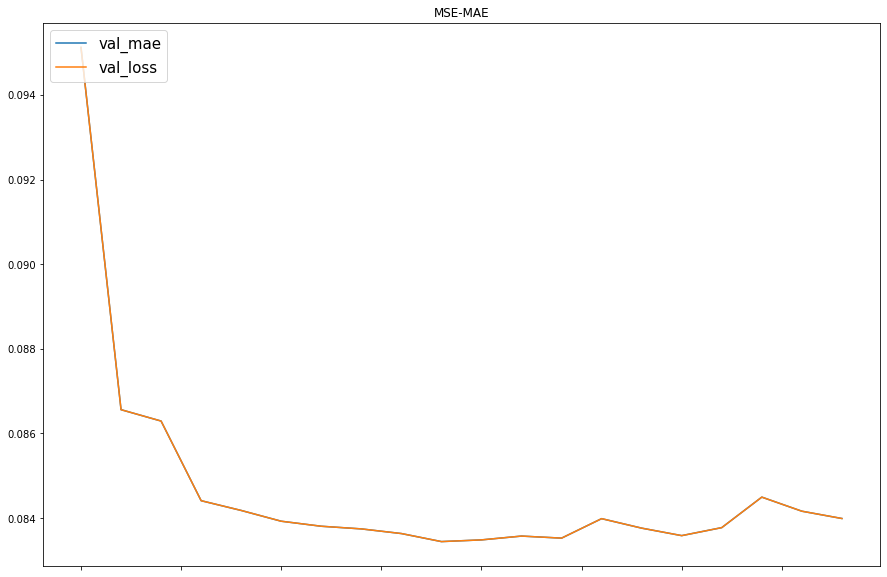

In [13]:
records     = pd.read_csv(modelname +'.csv')
plt.figure(figsize=(15,10))

ax          = plt.gca()
ax.set_xticklabels([])

plt.plot(records['val_mae'],label="val_mae")
plt.plot(records['val_loss'],label="val_loss")
plt.title('MSE-MAE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

plt.show()

### Sample Testing 

In [14]:
xls  = pd.ExcelFile('data/test_sample8000.xlsx')
test_sample = pd.read_excel(xls, 'TrafficMgmt')

# Apply Standardscalar to sample test data
test_sample[predictor_var] = scaler.fit_transform(test_sample[predictor_var])

In [15]:
# covert into input/output
test_sample_array = test_sample.to_numpy()
X_sample, y_sample = split_sequences(test_sample_array, n_steps_in, predict_next_no_of_output)
print(X_sample.shape, y_sample.shape)

(17, 3, 6) (17, 2)


In [16]:
predicted_value = model.predict(X_sample)
print('Predicted value : {} \n Actual Value    : {}' .format(predicted_value,y_sample))

Predicted value : [[0.04989624 0.04913196]
 [0.06374993 0.05009982]
 [0.05834658 0.05090124]
 [0.05869342 0.05107906]
 [0.03481928 0.04927474]
 [0.06419622 0.05062536]
 [0.05911859 0.04817221]
 [0.05887493 0.05105542]
 [0.05946609 0.04983602]
 [0.06067472 0.04648064]
 [0.05209518 0.05061629]
 [0.05986764 0.05112882]
 [0.05431668 0.05088611]
 [0.05200119 0.05068657]
 [0.05079285 0.04995306]
 [0.03111321 0.04836953]
 [0.06380217 0.0491922 ]] 
 Actual Value    : [[4.11381160e-02 6.28299090e-02]
 [6.28299090e-02 1.59614780e-01]
 [1.59614780e-01 9.09941638e-01]
 [9.09941638e-01 9.01061000e-04]
 [9.01061000e-04 1.32621545e-01]
 [1.32621545e-01 1.93137866e-01]
 [1.93137866e-01 4.08696860e-02]
 [4.08696860e-02 2.04278450e-02]
 [2.04278450e-02 6.94884150e-02]
 [6.94884150e-02 4.17434120e-02]
 [4.17434120e-02 1.90697068e-01]
 [1.90697068e-01 2.86340264e-01]
 [2.86340264e-01 6.49010570e-02]
 [6.49010570e-02 9.24329596e-01]
 [9.24329596e-01 7.57118120e-02]
 [7.57118120e-02 5.34953510e-02]
 [5.3495

In [17]:
print(np.sqrt(mean_squared_error(y_sample,predicted_value)))

0.30765267845195393
